In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
import utils_qm as uqm
import bt_tools as bt

In [2]:
data = pd.read_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/energies_homolytic.csv')
data_2 = data.loc[(data['Z1'] >= 6) & (data['Z1'] <= 9) & (data['Z2'] >= 6) & (data['Z2'] <= 9)].to_dict('list')
data_3 = data.loc[(data['Z1'] >= 14) & (data['Z2'] >= 14) & (data['Z1'] <= 17) & (data['Z2'] <= 17)].to_dict('list')
data_4 = data.loc[(data['Z1'] >= 32) & (data['Z2'] >= 32) & (data['Z1'] <= 35) & (data['Z2'] <= 35)].to_dict('list')
data_234 = data.loc[(data['Z1'] <= 9) & (data['Z2'] <= 9) | (data['Z1'] >= 14) & (data['Z2'] >= 14) & (data['Z1'] <= 17) & (data['Z2'] <= 17) | (data['Z1'] >= 32) & (data['Z2'] >= 32) & (data['Z1'] <= 35) & (data['Z2'] <= 35)].to_dict('list')

for d in [data_2, data_3, data_4, data_234]:
    d['unit'] = 630
    d['bfe type'] = 'homo'
    #d['nbfe'] = np.array(d['Z1'])*np.array(d['Z2'])-(np.array(d['Z1'])+np.array(d['Z2']))
    
bde_ref_2 = -630*np.array(data_2['bfe'])
bde_ref_3 = -630*np.array(data_3['bfe'])
bde_ref_4 = -630*np.array(data_4['bfe'])

In [10]:
# # original data from Paulin
# chi = {'H':2.1, 'Li':1.0, 'B':2.0, 'C':2.5, 'N':3.0, 'O':3.5, 'F':4.0, 'Si':1.8, 'P':2.1, 'S':2.5, 'Cl':3.0,
#       'Ge':1.8, 'As':2.0, 'Se':2.4, 'Br':2.8, 'I':2.5}

# revised by Allred
chi = {'H':2.2, 'Li':0.98, 'B':2.04, 'C':2.5, 'N':3.04, 'O':3.44, 'F':3.98, 'Si':1.9, 'P':2.19, 'S':2.58, 'Cl':3.16,
      'Ge':2.01, 'As':2.18, 'Se':2.55, 'Br':2.96, 'I':2.66}

Z2el = {5:'B', 6:'C', 7:'N', 8:'O', 9:'F', 14:'Si', 15:'P', 16:'S', 17:'Cl', 32:'Ge', 33:'As', 34:'Se', 35:'Br'}

def pauling_model(data):
    energies_pauling = []
    for ZA, ZB in zip(data['Z1'],data['Z2']):

        # get energy ZAZA and ZBZB
        E_AA = -data.loc[(data['Z1']==ZA) & (data['Z2']==ZA), 'bfe'].item()*630
        E_BB = -data.loc[(data['Z1']==ZB) & (data['Z2']==ZB), 'bfe'].item()*630
        # get chi_A, B
        el_A = Z2el[ZA]
        el_B = Z2el[ZB]

        chi_A = chi[el_A]
        chi_B = chi[el_B]
        # calculate bond energy
        E_AB = (E_AA + E_BB)/2 + 23*(chi_A - chi_B)**2
        energies_pauling.append(E_AB)
    energies_pauling = np.array(energies_pauling)
    return(energies_pauling)

def get_error(pred, ref, digits=2):
    MAE = np.round(np.abs(pred-ref).mean(), digits)
    MAE_std = np.round(np.abs(pred-ref).mean()/ref.std(), digits)
    return(MAE, MAE_std)

pauling_2 = pauling_model(pd.DataFrame(data_2))
MAE_2, MAE_std_2 = get_error(pauling_2, bde_ref_2, digits=2)
print(f'MAE = {MAE_2} ({MAE_std_2})')

pauling_3 = pauling_model(pd.DataFrame(data_3))
MAE_3, MAE_std_3 = get_error(pauling_3, bde_ref_3, digits=2)
print(f'MAE = {MAE_3} ({MAE_std_3})')

pauling_4 = pauling_model(pd.DataFrame(data_4))
MAE_4, MAE_std_4 = get_error(pauling_4, bde_ref_4, digits=2)
print(f'MAE = {MAE_4} ({MAE_std_4})')

MAE = 1.11 (0.05)
MAE = 1.97 (0.14)
MAE = 1.07 (0.1)


In [4]:
(1.11+1.97+1.07)/3

1.3833333333333335

In [5]:
(1.45+2.03+0.62)/3

1.3666666666666665

In [11]:
def pauling_delta_chi(data):
    delta_chi = []
    for ZA, ZB in zip(data['Z1'],data['Z2']):

        # get chi_A, B
        el_A = Z2el[ZA]
        el_B = Z2el[ZB]

        chi_A = chi[el_A]
        chi_B = chi[el_B]
        # calculate bond energy

        delta_chi.append(np.abs(chi_A-chi_B))
    delta_chi = np.array(delta_chi)
    return(delta_chi)


In [12]:
chi_2 = pauling_delta_chi(pd.DataFrame(data_2))
chi_3 = pauling_delta_chi(pd.DataFrame(data_3))
chi_4 = pauling_delta_chi(pd.DataFrame(data_4))

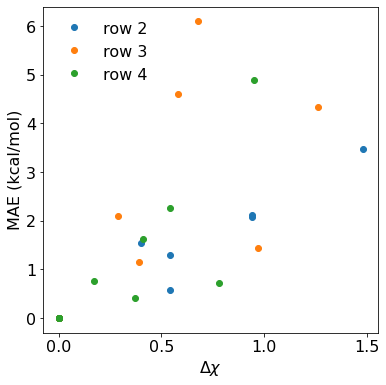

In [14]:
plt.rcParams['figure.figsize'] = [6,6]
plt.rcParams['font.size'] = 16
plt.plot(chi_2, np.abs(pauling_2-bde_ref_2), 'o', label = 'row 2')
plt.plot(chi_3, np.abs(pauling_3-bde_ref_3), 'o', label = 'row 3')
plt.plot(chi_4, np.abs(pauling_4-bde_ref_4), 'o', label = 'row 4')

plt.xlabel(r'$\Delta \chi$')
plt.ylabel(r'MAE (kcal/mol)')
plt.legend(frameon = False)

# plt.savefig(f'/home/sahre/work/bonding_trends/figures/results/chi_vs_MAE.png', bbox_inches = 'tight')